# Welcome to Esri QuickPitch v1.0

*** 

As a real estate broker, creating pitches can be time consuming and take focus away from engaging with a customer. With this tool, quickly generate a Story Map and market reports for a potential customer! Easily demonstrate to your customer the appeals of a property and some unqiue about the location, such as drive times to nearby attractions/amenities, as well as socioeconomic data of interest.

***

For this Notebook to work, you will need access to the following products:

* ArcGIS Online
* ArcGIS Business Analyst 
* ArcGIS Story Maps 


### <b><u>WARNING</u>: This application consumes credits. Communicate with your ArcGIS Online manager and learn more about ArcGIS Online credits at https://www.esri.com/en-us/arcgis/products/credits/overview .</b>


<center><b>Workflow</b></center>

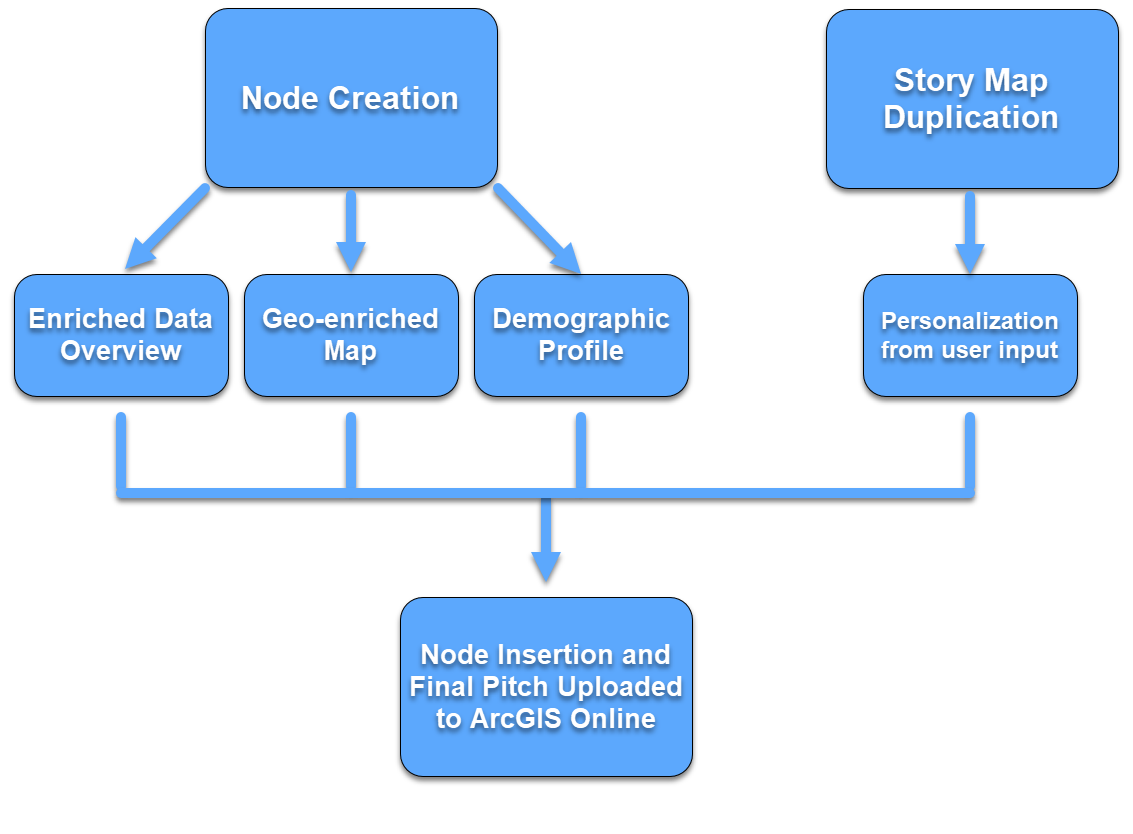

## Creating an ArcGIS Story Map template: 

### 1. Select your template

Navigate to the item page of the template you are interested in. There are two ways to do so: 

#### a. via ArcGIS StoryMaps

1. Visit https://storymaps.arcgis.com/stories . 
2. Find your Story Map of interest and select the three dots (image of 3 dots) on the bottom right corner of the card. 
3. Select <u>View Full Details</u>

#### b. via your ArcGIS Online content page

1. Visit the My Content page within your ArcGIS Online account. 
2. Click the hyperlink text with the name of your Story Map

### 2. Add the template tag to your Story Map 

1. On the ArcGIS Online item page for your Story Map, scroll down to <b>Tags</b> along the bottom right side and select <b>Edit</b>. 
2. Type <b>template</b> in the edit box. Do not capitalize any of the letters. 
3. Click <b>Save</b> and make sure that the <b>template</b> tag is added to the item. 

### Import the necessary libraries and connect to your GIS

In [19]:
from arcgis.apps import storymap
from arcgis.apps.storymap.story_content import TextStyles
from arcgis.mapping import WebMap
from arcgis.geoenrichment import Country, create_report
from arcgis.gis import GIS, User, Item
from getpass import getpass
from arcgis.features import GeoAccessor, FeatureLayer
from arcgis.geocoding import get_geocoders, geocode
from IPython.display import IFrame
from ast import literal_eval
import pandas as pd
import re

import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import Box

gis = GIS("home")

### Initialize project parameters and name your project

In [20]:
# class and input inits for reuse in code later:
class quickPitch(object):
    
    usa = Country("USA")
    
    def __init__(self) -> None:
        pass
        
    @classmethod
    def startProject(self):
        """
        Initialization params for the an instance of the quickPitch.
        """
        newProj = input("Please enter the name of your new project: ")
        esri_org = "https://" + gis.properties.urlKey + "." + gis.properties.customBaseUrl + "/"
        esri_username = gis.users.me.username
        
        projFolder = gis.content.create_folder('{} QuickPitch'.format(newProj))
        
        return newProj, esri_org, esri_username, projFolder
    
myProject = quickPitch.startProject()

Please enter the name of your new project: Colorado Property


### Run the next two code blocks and select your template from the drop down menu

In [21]:
def grab_templates():
    """
    Queries the user's GIS for all StoryMaps with the tag 'template' for use in template generation.
    """
    
    templates = gis.content.search(query = 'tags:"template"', item_type = "StoryMap")

    tempkeys = [item.title for item in templates]
    tempvalues = [item.id for item in templates]

    templates_dict = {tempkeys[i]: tempvalues[i] for i in range(len(tempkeys))}   
       
    list_of_templates = []
    
    for key in templates_dict.keys():
            list_of_templates.append(key)

    return list_of_templates, templates_dict

myTemplates = grab_templates()

print(f"Below are the available templates. Please select the template you would like to use: ")
template_selection = widgets.Dropdown(
                        options=myTemplates[0],
                        description = "Template: ",
                        disabled=False,
    )
template_selection

Below are the available templates. Please select the template you would like to use: 


Dropdown(description='Template: ', options=('Colorado StoryMap Template', 'StoryMap Template', 'Bay Area Story…

### Run this code block and enter the address you would like to enrich

In [12]:

# class for init of text based widgets
class addrTextBox(object):
    def __init__(self, ph):
        self.ph = ph
        self.addressNum = widgets.IntText(
                                placeholder = self.ph,
                                description = 'Enter the {}'.format(self.ph),
                                disabled = False)
        self.addressButton = widgets.Text(
                                placeholder = self.ph,
                                description = 'Enter the {}'.format(self.ph),
                                disabled = False)
        self.jsonPaste = widgets.Text(
                                placeholder = self.ph,
                                description = 'Paste Here',
                                disabled = False)

# Tab object children
streetNum = addrTextBox("Street Number")
streetName = addrTextBox("Street Name")
cityName = addrTextBox("City Name")
stateName = addrTextBox("State Name")
zipCode = addrTextBox("ZIP Code")

addrFields = [streetNum.addressNum, streetName.addressButton, cityName.addressButton, 
              stateName.addressButton, zipCode.addressButton]

addressInput = widgets.Tab(children = addrFields)
addressInput.set_title(0, "Street Number")
addressInput.set_title(1, "Street Name")
addressInput.set_title(2, "City")
addressInput.set_title(3, "State Abbreviation")
addressInput.set_title(4, "ZIP Code")

addressInput

### Would you like to include the navigation bar in your Story Map?

The navigation bar is an optional menu at the top of the Story Map that allows users to navigate different elements. See the image below:

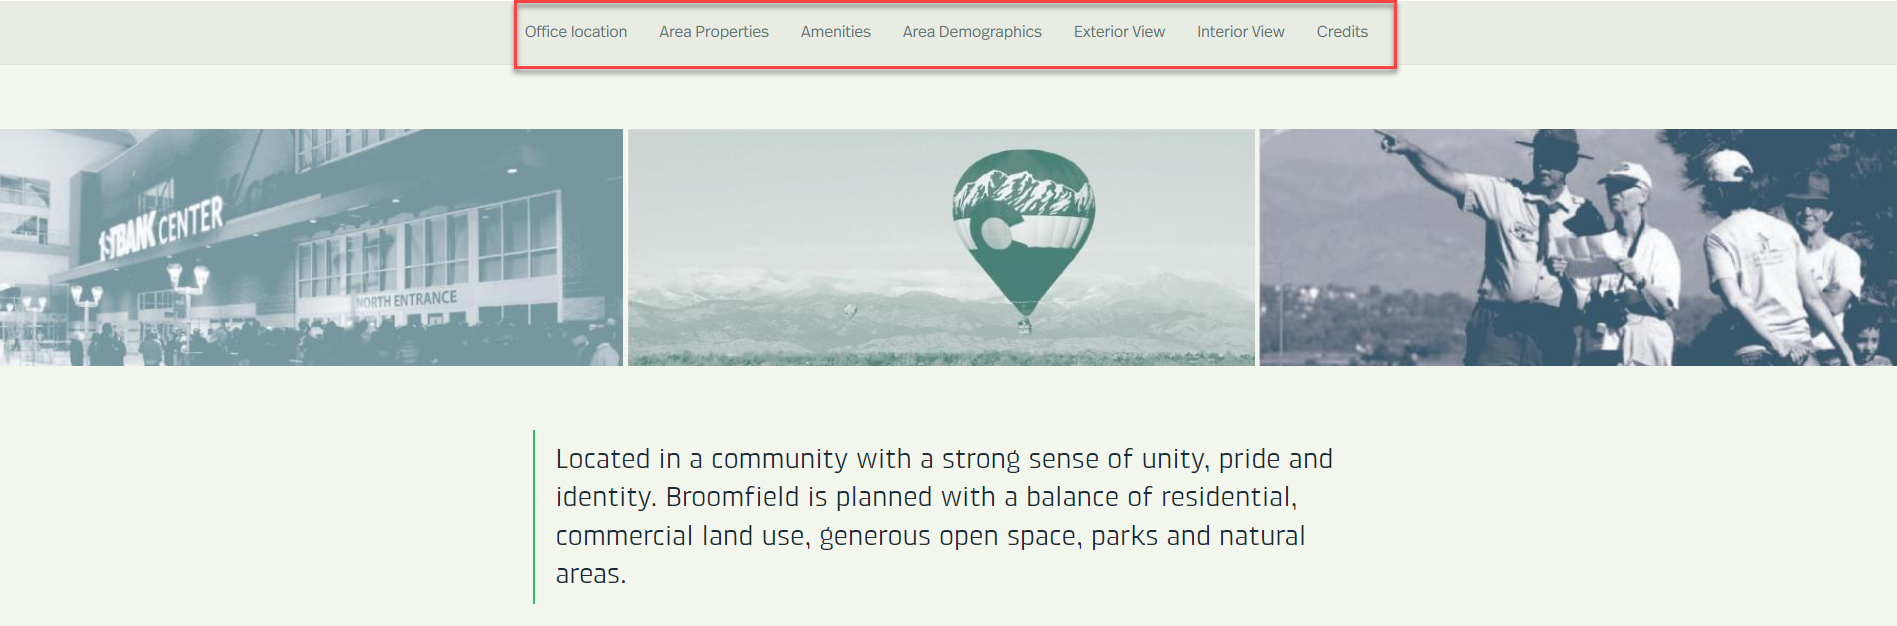

In [13]:
doNavBar = widgets.Checkbox(value = False, description = "Enable Navigation Bar in Story Map? ",
                           disabled = False)
doNavBar

Checkbox(value=False, description='Enable Navigation Bar in Story Map? ')

### Run the next two code blocks to select which enrichment variables you would like to include in the map

#### Once complete, Click "Copy JSON" and paste the results into the text box that says "Paste Here"

In [14]:
IFrame(src='https://la.arcgis.com/databrowser/index.html', width=700, height=600)

In [15]:
dbPaste = addrTextBox("Paste Here")
dbPaste.jsonPaste

Text(value='', description='Paste Here', placeholder='Paste Here')

In [16]:
# stores user input and formats string as dataframe to pass as arg into enrich()
myEnrichVars = literal_eval(dbPaste.jsonPaste.value)
myEnrichVars

['AtRisk.TOTPOP_CY',
 'populationtotals.POPDENS_CY',
 'populationtotals.TOTPOP20']

### What would you like your drive time to be in minutes?

In [17]:
myProxValue = addrTextBox("Drive time in minutes: ")
myProxValue.addressButton

Text(value='', description='Enter the Drive time in minutes: ', placeholder='Drive time in minutes: ')

### Creates the nodes which will be deployed into the new Story Map.

#### <u>The following code chunk will take a while to execute: be patient!</u>

In [26]:

def createNodes():
    """
    Generates the nodes for implementation in the QuickPitch Story Map. 
    Includes a geo-enriched map, report, and text formatting of geo-enriched data.
    """
    
    my_address = {'FullAddress' : [str(addrFields[0].value) + " " + addrFields[1].value 
                                    + "," + " " + addrFields[2].value + "," + " " 
                                    + addrFields[3].value + " " + addrFields[4].value]}
    address_df = pd.DataFrame(data=my_address)
    
    agol_geocoder = get_geocoders(gis)[0]
    geocode_df = GeoAccessor.from_df(address_df, address_column='FullAddress',
                     geocoder=agol_geocoder)
        
    enrich_df = quickPitch.usa.enrich(geocode_df, proximity_type="driving_time",
                           proximity_metric="minutes", proximity_value=myProxValue.addressButton.value, enrich_variables = myEnrichVars)

    # use enrichment data to create feature layer and convert it into a webmap: 
    myMap = enrich_df.spatial.to_featurelayer(myProject[0], gis = gis, service_name = myProject[0], folder = myProject[3].get('title'))
    
    # grab extent for setting it later in Web Map properties:
    wmExt = myMap.extent # returns two X-Y coordinate pairs, min and max respectively
    wmExt_min = wmExt[0]
    wmExt_max = wmExt[1]
    myExtent = {'xmin': wmExt_min[0], 'ymin': wmExt_min[1], 'xmax': wmExt_max[0], 'ymax': wmExt_max[1], 'spatialReference': {'wkid': 4326}}
    
    # begin web map conversion and geocoding
    to_wm = gis.content.get(myMap.id)

    my_wm = WebMap()
    my_wm.add_layer(to_wm)

    geocode_candidates = geocode(address=address_df['FullAddress'].iloc[0], as_featureset=True,
                                     location_type='rooftop')
    gc_df = geocode_candidates.sdf.sort_values(by='Score', ascending=False)
    site_lyr = gc_df.spatial.to_featurelayer(myProject[0] + " Location", gis= gis, 
                                             service_name = myProject[0], folder = myProject[3].get('title'))
    
    my_wm.add_layer(site_lyr)
    my_wm.basemap = 'satellite'
    wm_item_properties = {'title': myProject[0], 'snippet': 'Map used in QuickPitch StoryMap', 
                          'tags':'template', 'extent': myExtent}

    finalwm = my_wm.save(wm_item_properties, folder = myProject[3].get('title'))

    # init params for portal upload of geoenrich report:

    myreport = create_report(study_areas = [address_df['FullAddress'].iloc[0]], export_format="PDF", return_type = {'user':myProject[2],
                'title':myProject[0], 'url':myProject[1], 'folder':myProject[3].get('title')})
    
    print(f"Sucessfully created new content. Please refresh your AGOL content page.")

    return finalwm, myreport

myNodes = createNodes()

Sucessfully created new content. Please refresh your AGOL content page.


### Builds the Story Map from the template and inserts newly created nodes

In [27]:
## These functions grab the nessecary enrich variables for use in text box creation when calling buildTextbox():    

def grabAliases():
    """
    Dynamically grabs user-definied enrich variable aliases from the enrich_variables dataframe. Formats these aliases in a list for for easy querying
    """
    ev = quickPitch.usa.enrich_variables
    alias = []

    for v in myEnrichVars:
        tempQuery = ev.loc[ev['enrich_name'] == v, 'alias']
        alias.append(tempQuery.iat[0])

    return alias

def grabFieldNames():
    """
    Dynamically grabs user-defined enrich variable field names from the enrich_variables dataframe. Formats these in a list for easy querying.
    """
    
    ev = quickPitch.usa.enrich_variables
    fieldNames = []
    
    for v in myEnrichVars:
        tempQuery = ev.loc[ev['enrich_name'] == v, 'enrich_field_name']
        fieldNames.append(tempQuery.iat[0])
                
    return fieldNames



In [28]:
def buildTextbox():
    """
    Finalizes textbox formatting using grabFieldNames() and grabAliases(). Returns the textbox to insert into a Story Map text node.  
    """
    myAliases = grabAliases()
    myFields = grabFieldNames()
    myFieldsFinal = [re.sub(r'^.*?_', "", i).lower() for i in myFields]
    
    smStrings = []
    for i in range(len(myFieldsFinal)):
        smStrings.append("{} : {}".format(myAliases[i], demographic_df.loc[0, myFieldsFinal[i]]))

    textbox = "{}".format("\n".join(smStrings[0:]))
    
    return textbox

# globals for use in buildStoryMap():

getWM = WebMap(gis.content.get(myNodes[0].id))
demographic_lyr = FeatureLayer(url = getWM.layers[1].url)
demographic_df = demographic_lyr.query(where="1=1", as_df = True)

In [29]:

def buildStoryMap():    
    """
    Builds Story Map from the generated nodes in the createNodes() function. Adds a text box and 
    geo-enriched map. 
    """
    
    author = User(gis, username = myProject[2])
    
    selectedTemplate = template_selection.value
    
    my_story = storymap.StoryMap(item = myTemplates[1].get(selectedTemplate))
    
    dupestory = my_story.duplicate(title = myProject[0])
    
    # Container for new story based on the duplicate ID. 
    # Otherwise, saved changes will be made to the original StoryMap
    new_story = storymap.StoryMap(item = dupestory.id)
    
    new_story.cover(title = myProject[0], type = "minimal", by_line = author.fullName)
    
    if doNavBar.value == True:
        new_story.navigation(hidden=False)
    else:
        new_story.navigation(hidden=True)
    
    # Add enriched address map node
    smMap = storymap.Map(item = myNodes[0])
    
    # Report item must be made public in order to grab the REST API link for 
    # embed inside of a StoryMap
    new_story.add(content = smMap, display = "full")
    myreport_dict = myNodes[1]['results'][0]
    
    myreport_public = Item(gis = gis, itemid = myreport_dict.get('id'))
    
    upd = {'description' : 'Click me to view a demographic profile of the area!', 'title': '{} Report'.format(myProject[0]), 'snippet': 'Click me to view a demographic profile of the area!'}
    myreport_public.update(item_properties = upd)
    myreport_public.share(everyone=True)
    
    endpoint = myProject[1] + "sharing/rest/content/items/" + myreport_dict.get('id') + "/data"
    
    baReport = storymap.Embed(path = endpoint)
    new_story.add(content = baReport, display = "card", caption = "Click me to view a demographic profile of the area!")
      
    # Add Text Box with dynamic enrich information
    
    myTextbox = buildTextbox()
    
    reportNode = storymap.Text(text = "<strong>{}</strong>".format(myTextbox), style = TextStyles.QUOTE)
    new_story.add(content = reportNode)
    new_story.save(publish = True)
        
    print(f"Success! Please refresh your content page.")
    
buildStoryMap()
    

Success! Please refresh your content page.


### Launch your Story Map

Your Story Map is now generated! There is one more step to complete and then your Story Map will be ready for viewing. This step simply gives Story Maps the permission to use our newly generated layers.

1. Navigate to https://storymaps.arcgis.com/stories . 
2. Select the three dots on the card of the Story Map you generated.
3. Click 'Edit'

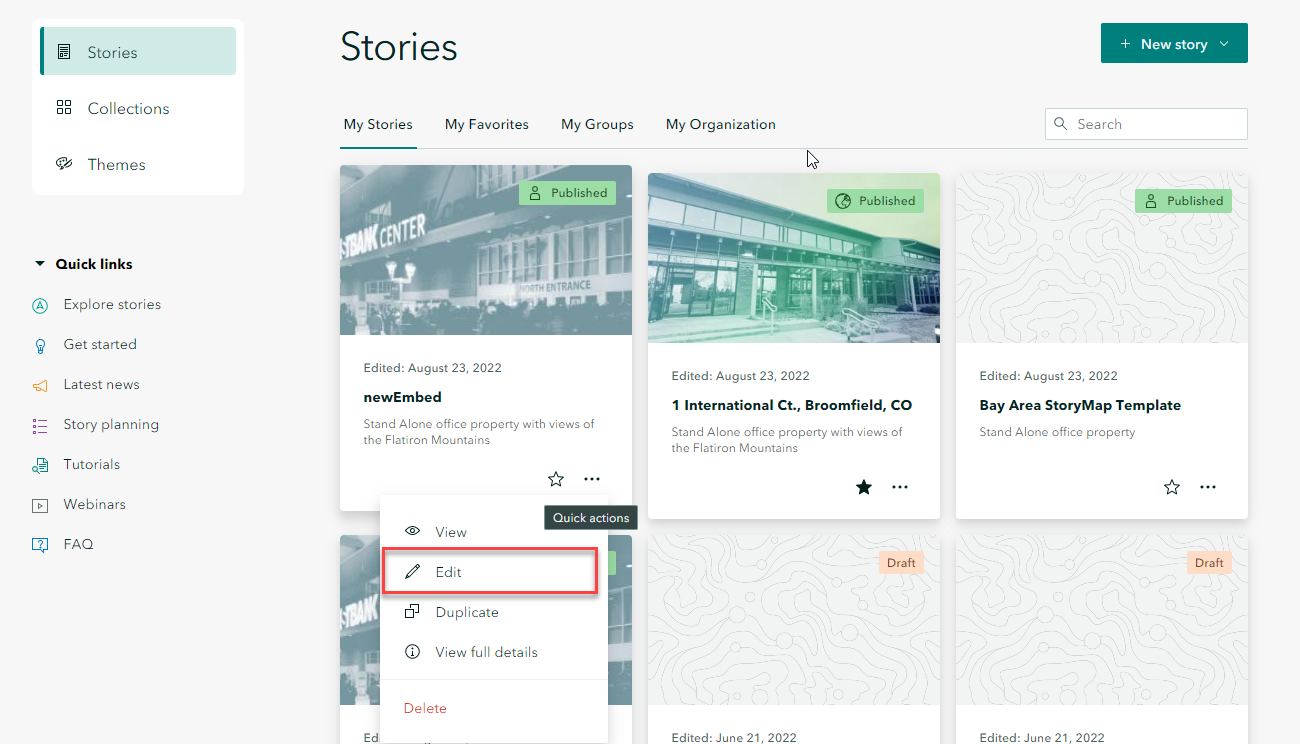

4. Follow and accept all the prompts, including layer permission access.

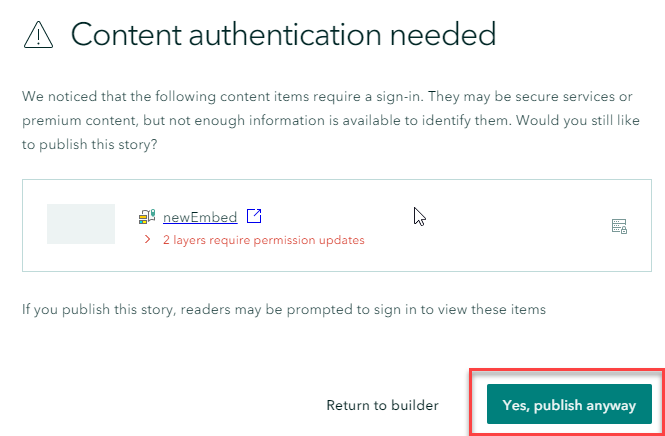

5. Your Story Map should be complete and display on your screen!